### Reinforce with baseline

В работе рассматриваются работы алгоритмов REINFORCE with Baseline. Реализации алгоритмов

**Реализации алгоритмов**

Можно найти в папке `scripts`


#### Сетапы экспериментов

Кол-во эпизодов обучения - $1000$ или ранняя остановка при средней награде за последние 20 эпизодов > 495

Hidden dimention для всех моделей - 32

фактор дисконтирования $\gamma=0.99$

коэффициенты энтропийной регуляризации $\beta$ - linear reduction 0.01 -> 0.001 (np.linspace(0.01, 0.001))

In [3]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from collections import defaultdict

env = gym.make('CartPole-v1')
DEVICE = 'cpu'

GAMMA = 0.99  # Коэффициент дисконтирования


EPOCHS_RL = 1000
BATCH_SIZE_RL = 1  
LR = 0.01
LR_VALUE = 0.01

EPOCHS_BC = 20
EXPERT_TRAJECTORIES = 100



In [4]:
obs_size = 4
action_size = 2
HIDDEN_SIZE = 32

class Policy(nn.Module):
    def __init__(self, observation_size, action_size):
        super(Policy, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(observation_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, action_size)
        )

    def forward(self, x):
        return self.net(x)

class Value(nn.Module):
    def __init__(self, observation_size):
        super(Value, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(observation_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, 1)
        )

    def forward(self, x):
        return self.net(x)

In [5]:
def collect_trajectories(env, policy_net, min_steps):
    """Собирает траектории, пока не наберется min_steps шагов."""
    trajectories = []
    total_steps = 0
    
    while total_steps < min_steps:
        trajectory = {'states': [], 'actions': [], 'rewards': [], 'log_probs': [], 'logits': []}
        state, _ = env.reset()
        done = False
        
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
            logits = policy_net(state_tensor)
            dist = Categorical(logits=logits)
            action = dist.sample()
            log_prob = dist.log_prob(action)
            
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated
            
            trajectory['states'].append(state)
            trajectory['actions'].append(action.item()) # Сохраняем как число
            trajectory['rewards'].append(reward)
            trajectory['log_probs'].append(log_prob)
            trajectory['logits'].append(logits)
            state = next_state
        
        trajectories.append(trajectory)
        total_steps += len(trajectory['rewards'])
        
    return trajectories

def calculate_returns(rewards, gamma):
    """Считает дисконтированные награды (G_t)."""
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    return returns

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
from tqdm.auto import tqdm

# Assuming these are defined elsewhere
# from your_utils import Policy, Value, collect_trajectories, calculate_returns
# DEVICE = torch.device(...)
# LR, GAMMA, EPOCHS_RL, BATCH_SIZE_RL = ...

def train_vpg(env, baseline_type='mean_reward', use_entropy=False, entropy_schedule=None):
    """
    Trains a policy using Vanilla Policy Gradient (VPG).

    Fixes:
    1. Correctly calculates baselines ('mean_reward', 'rloo') using the total 
       discounted return (G_0) of episodes, not the undiscounted sum of rewards.
    2. Pre-calculates baselines for the entire batch to improve efficiency and clarity.
    """
    print(f"\n--- Starting training: VPG with baseline='{baseline_type}' and entropy={use_entropy} ---")
    
    obs_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    
    policy_net = Policy(obs_size, action_size).to(DEVICE)
    policy_optimizer = optim.Adam(policy_net.parameters(), lr=LR)
    
    value_net, value_optimizer = None, None
    if baseline_type == 'value_function':
        value_net = Value(obs_size).to(DEVICE)
        value_optimizer = optim.Adam(value_net.parameters(), lr=LR)
        
    rewards_history = []
    
    success_threshold = 495
    with tqdm(range(EPOCHS_RL), desc=f"Training ({baseline_type})") as epochs:
        for epoch in epochs:
            # 1. Collect data
            trajectories = collect_trajectories(env, policy_net, BATCH_SIZE_RL)
            
            # 2. Prepare data for update
            policy_loss_terms = []
            value_loss_terms = []
            
            # Record average undiscounted reward for history tracking
            avg_total_reward = np.mean([sum(t['rewards']) for t in trajectories])
            rewards_history.append(avg_total_reward)

            # First, calculate returns-to-go for all trajectories
            all_returns = [torch.tensor(calculate_returns(t['rewards'], GAMMA), dtype=torch.float32).to(DEVICE) for t in trajectories]
            
            # Second, get the total discounted return (G_0) for each trajectory to compute baselines
            total_discounted_returns = [returns[0].item() for returns in all_returns]
            
            baselines = [0] * len(trajectories) 
            if baseline_type == 'mean_reward':
                batch_baseline = np.mean(total_discounted_returns)
                baselines = [batch_baseline] * len(trajectories)
            
            elif baseline_type == 'rloo':
                sum_of_G0 = sum(total_discounted_returns)
                n_trajectories = len(trajectories)
                if n_trajectories > 1:
                    baselines = [
                        (sum_of_G0 - total_discounted_returns[i]) / (n_trajectories - 1)
                        for i in range(n_trajectories)
                    ]
                else:
                    baselines = [0]
            
            if epoch > 30:
                epochs.set_postfix(avg_loss=np.mean(rewards_history[-20:]))
                if np.mean(rewards_history[-20:]) > success_threshold:
                    print(f"\nSuccess threshold reached at epoch {epoch}!")
                    return policy_net, rewards_history

            # 3. Compute losses for each trajectory
            for i, traj in enumerate(trajectories):
                returns = all_returns[i]
                log_probs = torch.cat(traj['log_probs'])

                advantage = None
                if baseline_type == 'mean_reward' or baseline_type == 'rloo':
                    # Use the pre-calculated baseline for the current trajectory
                    baseline = baselines[i]
                    advantage = returns - baseline
                
                elif baseline_type == 'value_function':
                    states = torch.tensor(np.array(traj['states']), dtype=torch.float32).to(DEVICE)
                    values = value_net(states).squeeze()
                    advantage = returns - values
                    # `.detach()` is crucial here to stop gradients from flowing into the value net
                    # from the policy loss.
                    value_loss_terms.append(F.mse_loss(values, returns.detach(), reduction='none'))

                # `.detach()` on advantage is critical for the value_function case, but harmless for others.
                actor_loss = -log_probs * advantage.detach()

                if use_entropy:
                    entropy_beta = entropy_schedule[epoch]
                    logits = torch.cat(traj['logits'])
                    # We want to maximize entropy, so we subtract it from the loss
                    entropy = Categorical(logits=logits).entropy()
                    actor_loss -= entropy_beta * entropy

                policy_loss_terms.append(actor_loss)

            # 4. Perform updates
            policy_optimizer.zero_grad()
            policy_loss = torch.cat(policy_loss_terms).sum()
            policy_loss.backward()
            policy_optimizer.step()
            
            if value_net:
                value_optimizer.zero_grad()
                value_loss = torch.cat(value_loss_terms).sum()
                value_loss.backward()
                value_optimizer.step()
                
    return policy_net, rewards_history

c:\Users\user\git_repos\TOY-DOUBLE-DECENT\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_results(results, smoothing_window=50, title=None):
    """
    Строит улучшенные, сглаженные графики обучения.
    
    Args:
        results (list of tuples): Список кортежей, где каждый кортеж 
                                  содержит (имя_метода, список_наград).
        smoothing_window (int): Окно для скользящего среднего. 
                                Чем больше значение, тем более гладкий график.
                                Установите 1, чтобы отключить сглаживание.
        title (str, optional): Заголовок графика.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(14, 8))

    line_styles = ['-', '--', '-.', ':', '-']
    colors = plt.get_cmap('tab10').colors

    for i, (name, rewards) in enumerate(results):

        rewards_smoothed = pd.Series(rewards).rolling(smoothing_window, min_periods=1).mean()
        
        plt.plot(rewards_smoothed, 
                 label=name, 
                 color=colors[i % len(colors)], 
                 linestyle=line_styles[i % len(line_styles)],
                 linewidth=2.5)

    if title is None:
        title = f'Сравнение методов обучения (сглаживание по {smoothing_window} эпизодам)'
    plt.title(title, fontsize=16)
    
    plt.xlabel('Episode', fontsize=12)
    plt.ylabel('Smoothed Reward', fontsize=12)
    plt.legend(loc='upper left', fontsize=10)
    
    plt.ylim(0, 550) 
    plt.xlim(0)

    plt.tight_layout()
    plt.show()

# Часть 1: REINFORCE with mean reward, RLOO and Value functions

Обучим политики разными методами и посмотрим на различия

In [345]:
results = []
# policy = Policy(obs_size, action_size).to(DEVICE)
# optimizer = optim.Adam(policy.parameters(), lr=LR)

entropy_schedule = np.linspace(0.01, 0.001, EPOCHS_RL)
expert_policy, r = train_vpg(env, use_entropy=True, entropy_schedule=entropy_schedule)
results.append(('mean reward with entropy', r))


--- Starting training: VPG with baseline='mean_reward' and entropy=True ---


Training (mean_reward):  32%|███▎      | 325/1000 [00:11<00:24, 27.37it/s, avg_loss=500]  


Success threshold reached at epoch 325!


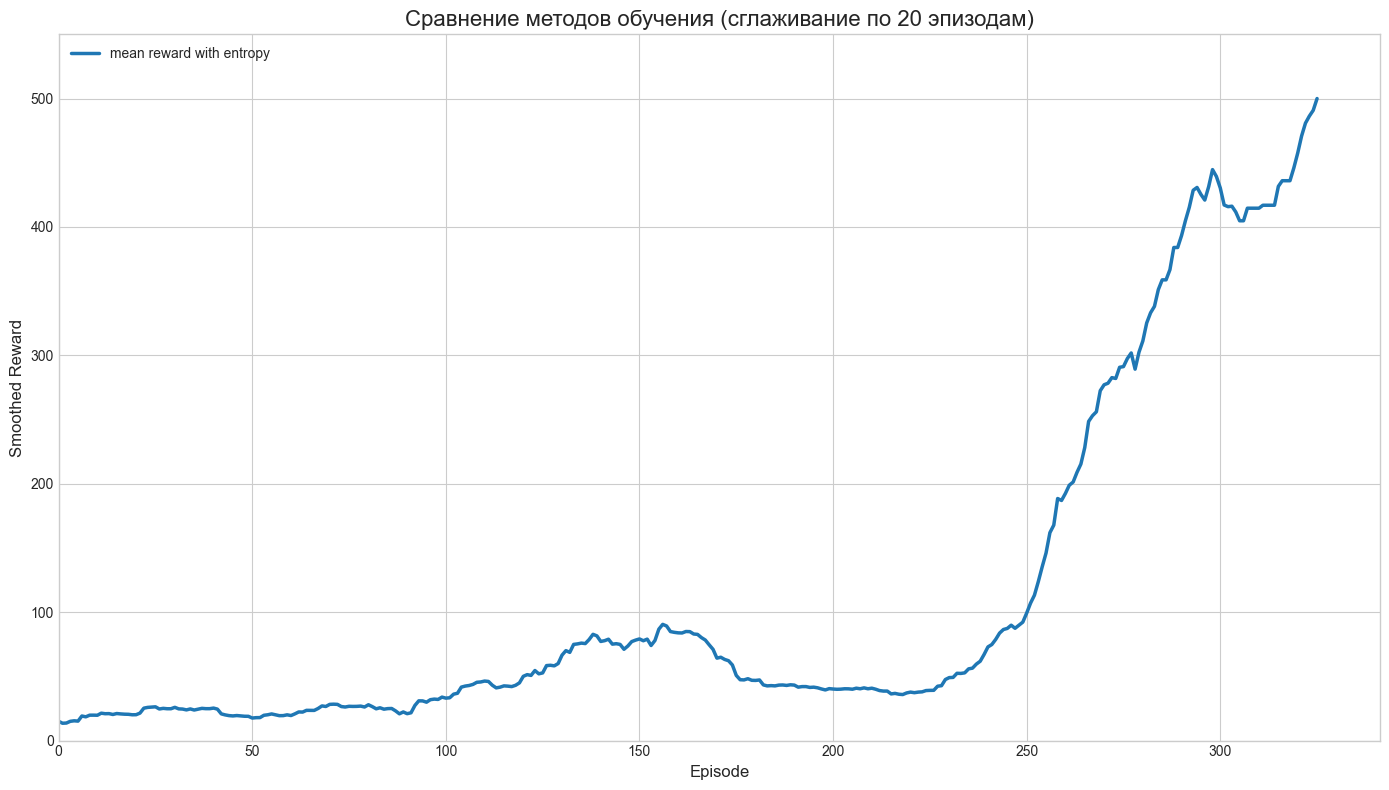

In [346]:
plot_results([results[-1]], smoothing_window=20)

In [333]:
policy = Policy(obs_size, action_size).to(DEVICE)
optimizer = optim.Adam(policy.parameters(), lr=LR)

EPOCHS_RL=5000
entropy_schedule = np.linspace(0.01, 0.001, EPOCHS_RL)
expert_policy, r = train_vpg(env, use_entropy=True, entropy_schedule=entropy_schedule)
EPOCHS_RL=1000
# results.append(('mean reward with entropy', r))


--- Starting training: VPG with baseline='mean_reward' and entropy=True ---


Training (mean_reward): 100%|██████████| 5000/5000 [00:59<00:00, 83.42it/s, avg_loss=17.4] 


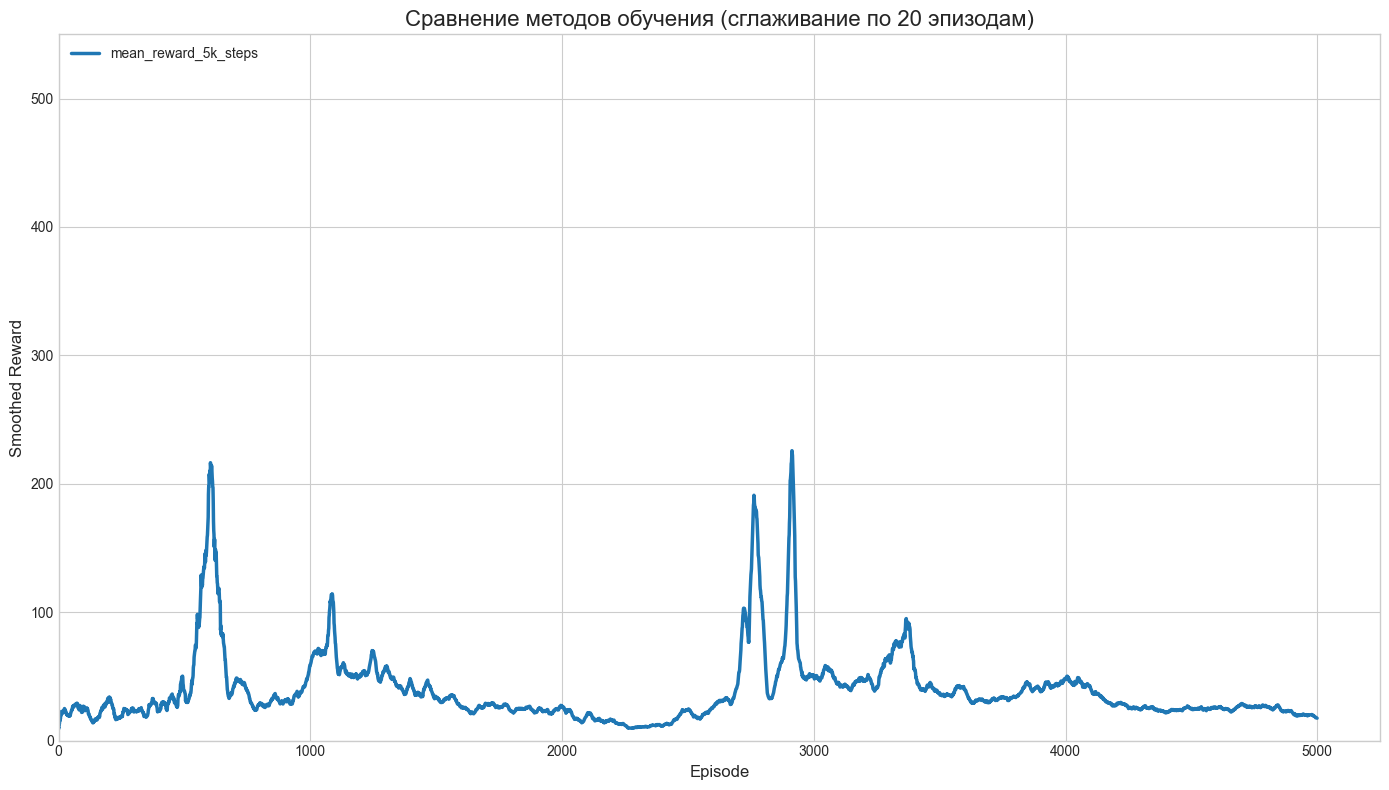

In [334]:
plot_results([('mean_reward_5k_steps', r)], smoothing_window=20)

In [347]:
entropy_schedule = np.linspace(0.01, 0.001, EPOCHS_RL)
expert_policy, r = train_vpg(env, baseline_type='rloo', use_entropy=True, entropy_schedule=entropy_schedule)
results.append(('rloo with entropy', r))


--- Starting training: VPG with baseline='rloo' and entropy=True ---


Training (rloo): 100%|██████████| 1000/1000 [00:17<00:00, 58.42it/s, avg_loss=9.4] 


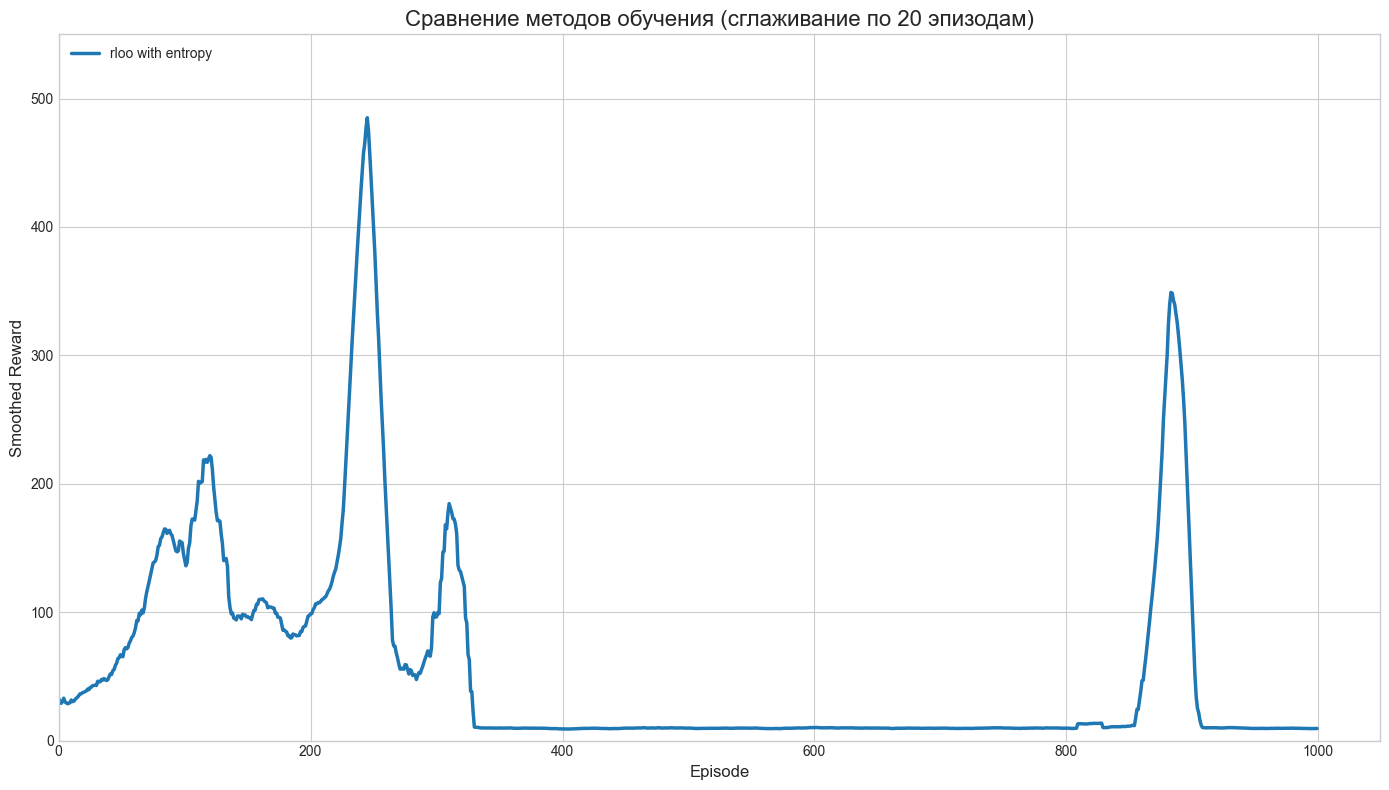

In [348]:
plot_results([results[-1]], smoothing_window=20)

In [349]:
# entropy_schedule = np.linspace(0.01, 0.001, EPOCHS_RL)
expert_policy, r = train_vpg(env, baseline_type='rloo', use_entropy=False)
results.append(('rloo without entropy', r))


--- Starting training: VPG with baseline='rloo' and entropy=False ---


Training (rloo):  34%|███▍      | 343/1000 [00:18<00:35, 18.27it/s, avg_loss=500] 


Success threshold reached at epoch 343!


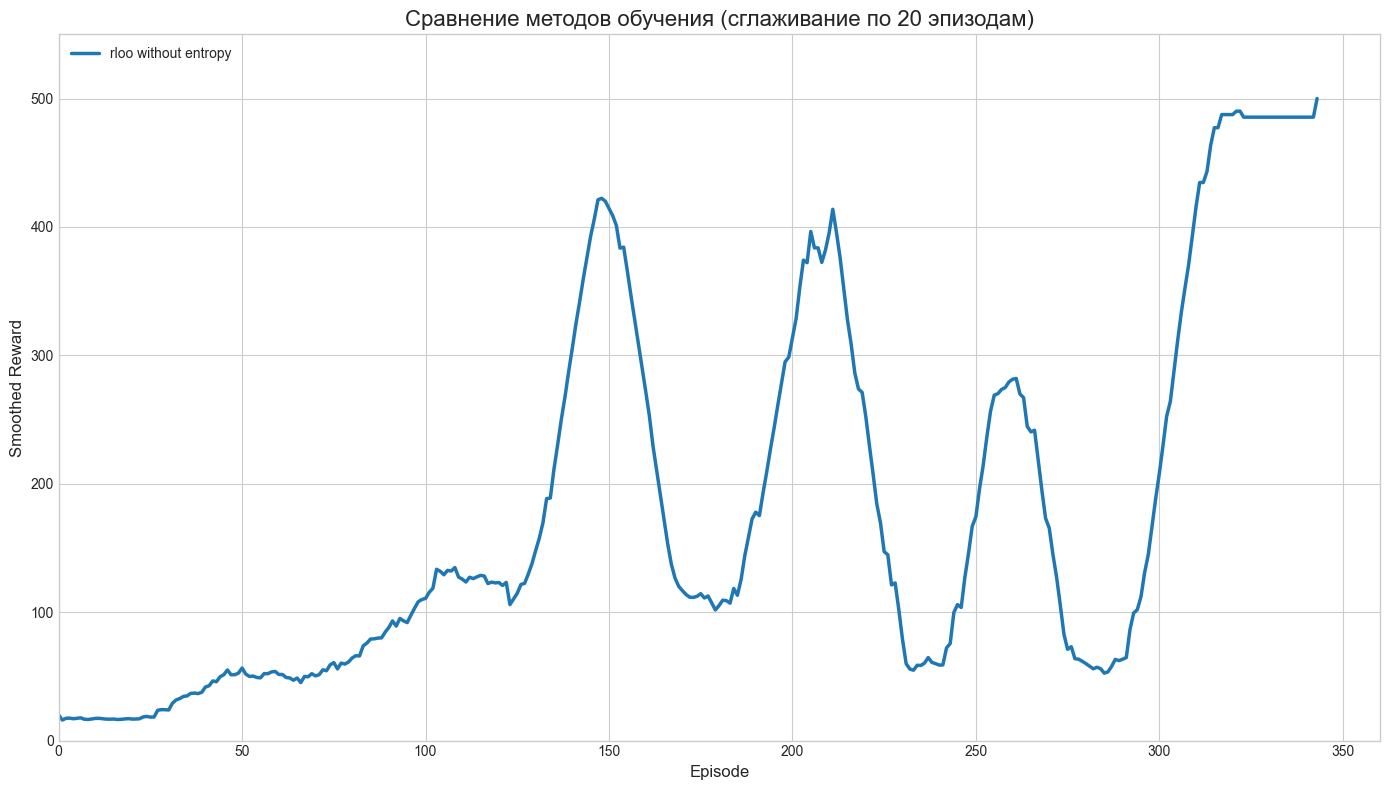

In [350]:
plot_results([results[-1]], smoothing_window=20)

In [351]:
# entropy_schedule = np.linspace(0.01, 0.001, EPOCHS_RL)
expert_policy, r = train_vpg(env, baseline_type='value_function', use_entropy=False)
results.append(('value fun without entropy', r))


--- Starting training: VPG with baseline='value_function' and entropy=False ---


Training (value_function):  17%|█▋        | 167/1000 [00:09<00:46, 17.84it/s, avg_loss=500] 


Success threshold reached at epoch 167!


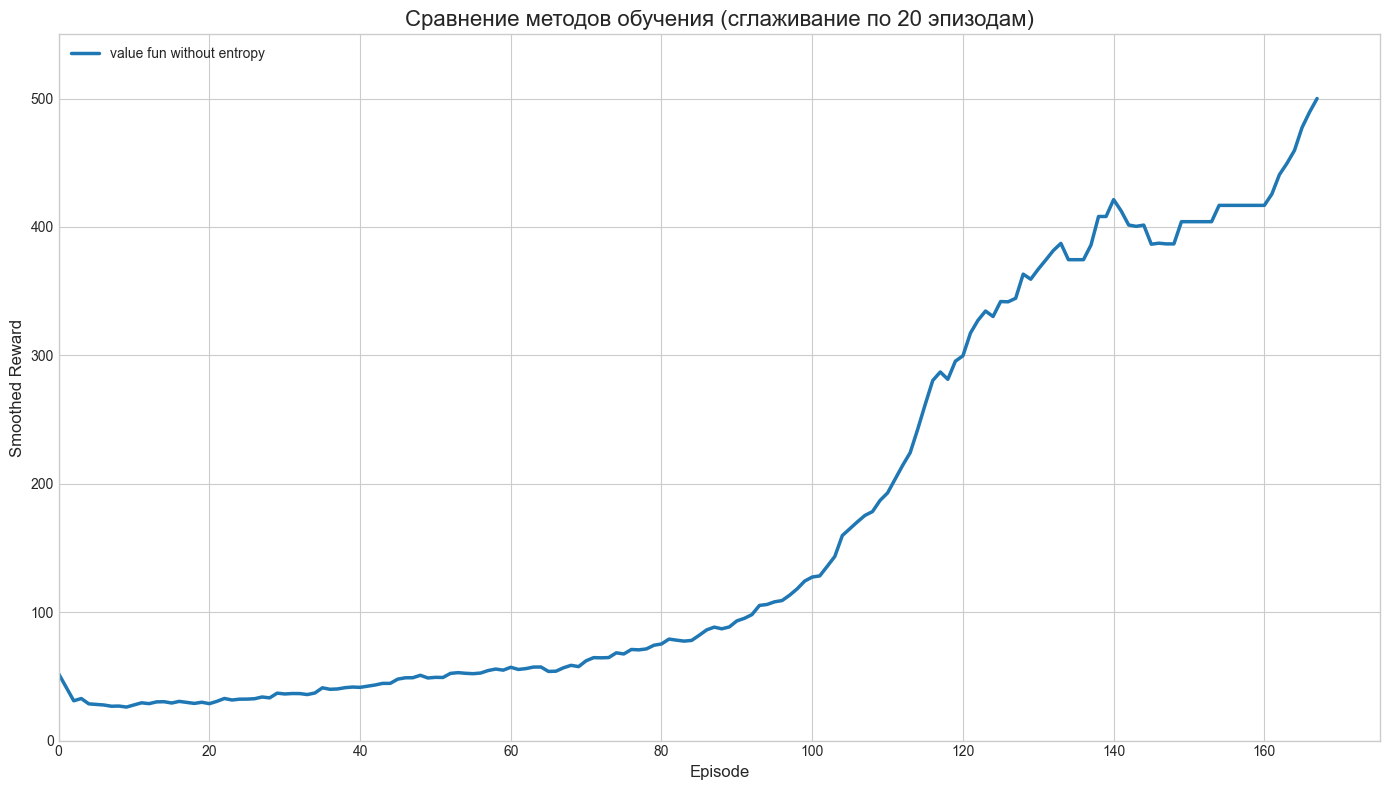

In [352]:
plot_results([results[-1]], smoothing_window=20)

In [353]:
entropy_schedule = np.linspace(0.01, 0.001, EPOCHS_RL)
expert_policy, r = train_vpg(env, baseline_type='value_function', use_entropy=True, entropy_schedule=entropy_schedule)
results.append(('value function with entropy', r))

expert_path = "expert_policy.pth"
torch.save(expert_policy.state_dict(), expert_path)


--- Starting training: VPG with baseline='value_function' and entropy=True ---


Training (value_function):  22%|██▏       | 220/1000 [00:12<00:45, 17.11it/s, avg_loss=500] 


Success threshold reached at epoch 220!


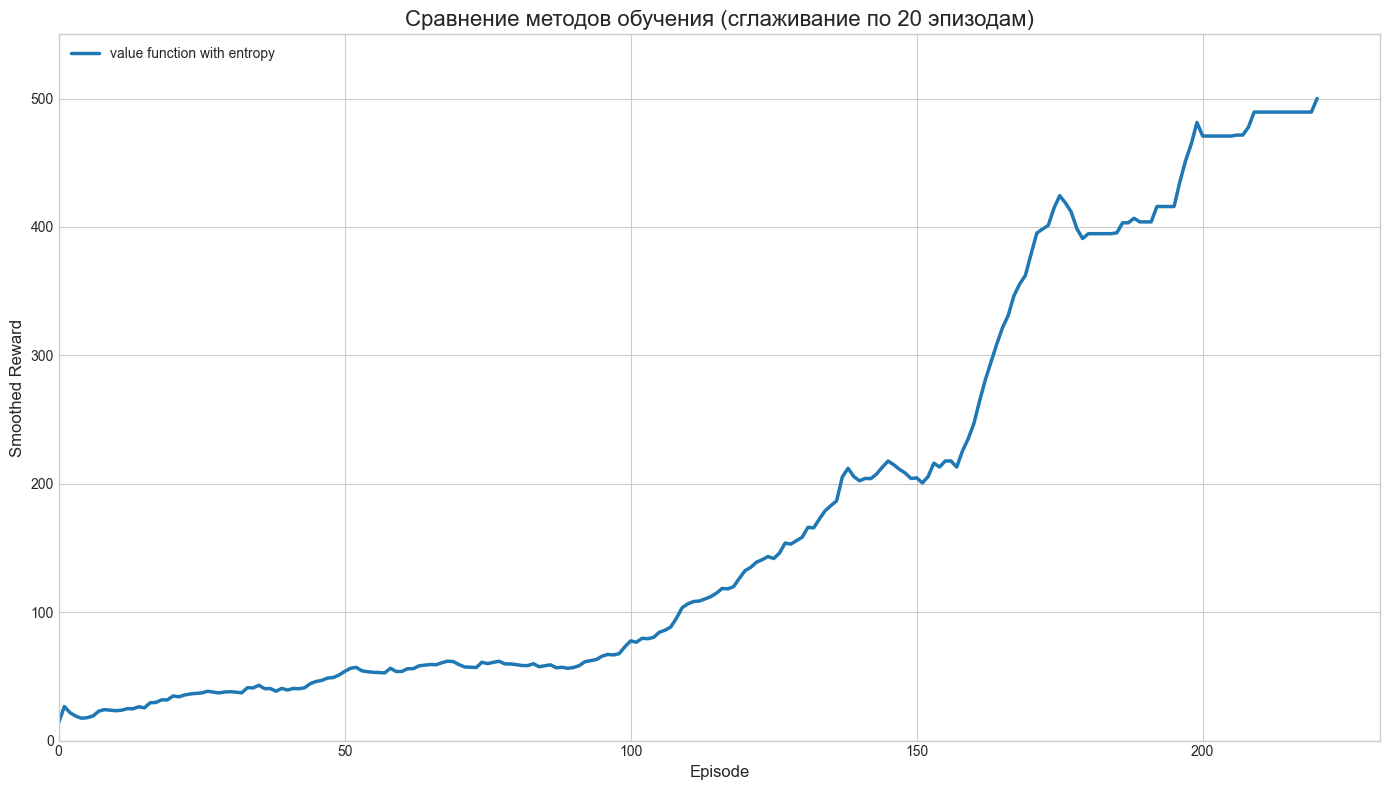

In [354]:
plot_results([results[-1]], smoothing_window=20)

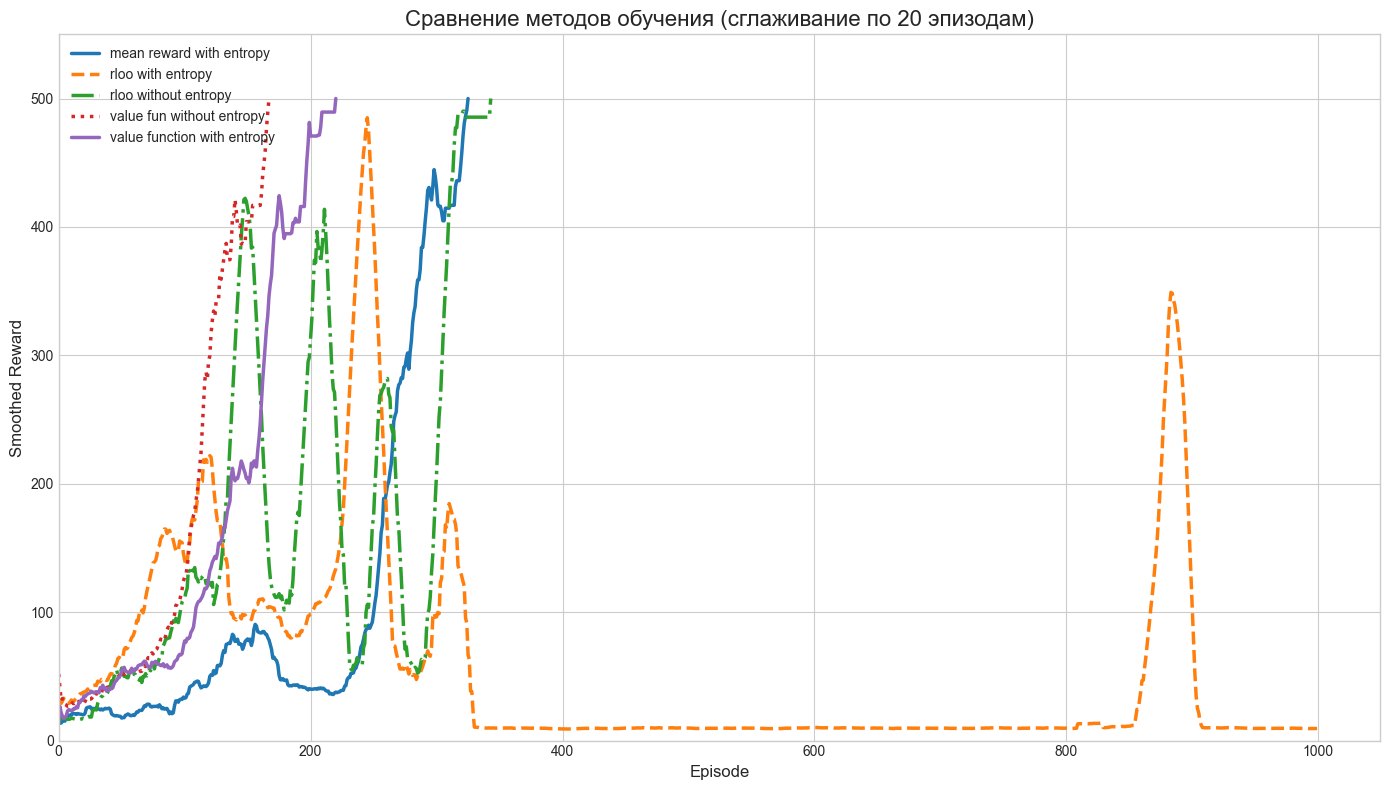

In [355]:
plot_results(results, smoothing_window=20)

## Эксперименты

**Mean reward:** эпизодически влетала в оптимумы, но вскоре теряла в качестве. Прии данном сетапе гиперов значение награды почти никогда не сходится. (помогает lr scheduling) 

**RLOO:** Без энтропии всегда уверено сходится к максимуму в районе 200-400 шага. С энтропией сходится дольше, но тоже почти всегда успешно. 

**Value function:** Самый уверенный из алгоритмов, стабильно сходится раньше всех в обоих сетапах, но самый тяжеловесный, требует обучения Value функции

# Часть 2: Behavior cloning

#### Сетап экспериментов

В качестве учителя была выбрана одна из моделей, среди обученных на предыдущем шаге ($\text{REINFORCE}$ с Value function бейзлайном и вклююченной убывающей энтропией) . Для генерации пар state-action пар было сохранено 100 траекторий политики, затем были отобраны только те, у которых траектории имели максимальный reward. Затем все пары были добавлены в общий датасет и перемешаны. Обучение длилось 20 эпох, размер батча составлял $64$, шаг обучения $1e-2$. Для обучения использовался $CE$-loss.

Затем для валидации были эврестически выбраны редкие состояния, из множества которых на каждом этапе семплируется одно из состояний, с которого стартует политика. Для сравнения взят средний результат, полученный RL политикой и BC политикой 

In [357]:
def generate_expert_dataset(env, expert_policy, num_trajectories):
    """Генерация датасета (s, a) с помощью эксперта."""
    print(f"\n--- Generating expert dataset of {num_trajectories} trajectories ---")
    dataset = {'states': [], 'actions': []}
    
    collected_trajectories = 0
    pbar = tqdm(total=num_trajectories, desc="Collecting expert data")
    while collected_trajectories < num_trajectories:
        state, _ = env.reset()
        done = False
        
        episode_reward = 0
        traj_states, traj_actions = [], []
        
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
            with torch.no_grad():
                logits = expert_policy(state_tensor)
            action = torch.argmax(logits, dim=1).item()
            
            traj_states.append(state)
            traj_actions.append(action)
            
            state, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            done = terminated or truncated

        # Добавляем только "идеальные" траектории
        if episode_reward >= 495:
            dataset['states'].extend(traj_states)
            dataset['actions'].extend(traj_actions)
            collected_trajectories += 1
            pbar.update(1)
    pbar.close()
    return np.array(dataset['states']), np.array(dataset['actions'])

def train_bc_agent(env, expert_states, expert_actions):
    """Обучение агента в supervised-стиле."""
    print("\n--- Starting training: Behavioural Cloning ---")
    
    obs_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    
    bc_policy = Policy(obs_size, action_size).to(DEVICE)
    optimizer = optim.Adam(bc_policy.parameters(), lr=LR)
    loss_fn = nn.CrossEntropyLoss()
    
    dataset = TensorDataset(torch.from_numpy(expert_states).float(), torch.from_numpy(expert_actions).long())
    data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
    
    for epoch in tqdm(range(EPOCHS_BC), desc="Training BC Agent"):
        for states_batch, actions_batch in data_loader:
            states_batch, actions_batch = states_batch.to(DEVICE), actions_batch.to(DEVICE)
            
            optimizer.zero_grad()
            action_logits = bc_policy(states_batch)
            loss = loss_fn(action_logits, actions_batch)
            loss.backward()
            optimizer.step()
            
    print("BC training finished.")
    return bc_policy


In [358]:
loaded_expert_policy = Policy(obs_size, action_size).to(DEVICE)
loaded_expert_policy.load_state_dict(torch.load(expert_path))
loaded_expert_policy.eval()

# Сгенерируем датасет и обучим BC-агента
expert_states, expert_actions = generate_expert_dataset(env, loaded_expert_policy, EXPERT_TRAJECTORIES)
bc_policy = train_bc_agent(env, expert_states, expert_actions)




--- Generating expert dataset of 100 trajectories ---



--- Starting training: Behavioural Cloning ---


Training BC Agent: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]

BC training finished.


In [366]:
def evaluate_policy(env, policy, num_episodes=100, bad_start=False):
    """Оценивает политику, возвращает среднюю награду."""
    total_rewards = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        if bad_start:
            import random
            bad_state = random.choice([np.array([2, -1, -0.15, 0]), np.array([-2, 1, 0.15, 0]), np.array([2, -1, -0.1, -0.05]), np.array([-2, 1, 0.1, 0.05])])
            env.unwrapped.state = bad_state
            state = bad_state

        done = False
        episode_reward = 0
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
            with torch.no_grad():
                action = torch.argmax(policy(state_tensor), dim=1).item()
            state, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            done = terminated or truncated
        total_rewards.append(episode_reward)
    return np.mean(total_rewards)

In [312]:
    # Оценка BC агента
    print("\n--- Evaluating Behavioural Cloning Agent ---")
    
    # Эксперимент 1 (BC): Стандартный старт
    avg_reward_bc_normal = evaluate_policy(env, bc_policy, num_episodes=100)
    print(f"BC Agent - Average reward from normal start: {avg_reward_bc_normal:.2f}")

    # Эксперимент 2 (BC): Старт из "плохого" состояния
    avg_reward_bc_bad = evaluate_policy(env, bc_policy, num_episodes=100, bad_start=True)
    print(f"BC Agent - Average reward from 'bad' start: {avg_reward_bc_bad:.2f}")

    # Сравнение с экспертом
    print("\n--- Comparing with RL Expert ---")
    avg_reward_expert_bad = evaluate_policy(env, loaded_expert_policy, num_episodes=100, bad_start=True)
    print(f"RL Expert - Average reward from 'bad' start: {avg_reward_expert_bad:.2f}")


--- Evaluating Behavioural Cloning Agent ---
BC Agent - Average reward from normal start: 500.00
BC Agent - Average reward from 'bad' start: 19.00

--- Comparing with RL Expert ---
RL Expert - Average reward from 'bad' start: 500.00


#### Поведение политики в неизвестных состояниях

Одним из недостатков подхода $\text{Behavioral Cloning}$ является тот факт, что агент, попадающий в состояние, которого не было в обучающей выборке может начать вести себя непредсказуемо. 

Результат Выше был черипикнут, часто BC модель также как и основная политика выбивает максимум, но в среднем заметно ухудшение метрик на редких стейтах.